In [1]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 91.1 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import wave,os,librosa,tqdm,time,shutil
import pandas as pd
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa, os, cv2, pickle, tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization,Input
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE

2025-06-23 13:22:56.613974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750684976.812924      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750684976.873446      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
feats = pd.read_csv('/kaggle/input/iemocap-opensmile-features-wo-nr-and-trim/IEMOCAP_OpenSMILE_Features_2.csv')
feats.label.value_counts()

label
frustrated    1849
neutral       1708
happy         1636
angry         1103
sad           1084
surprised      107
fear            40
disgust          2
Name: count, dtype: int64

In [5]:
feats = feats[feats.label.isin(['neutral','happy','angry','sad','frustrated'])]
feats.label.value_counts()

label
frustrated    1849
neutral       1708
happy         1636
angry         1103
sad           1084
Name: count, dtype: int64

In [6]:
def split_preprocess(df,apply_smote=False,rs=536,returnscalerle=False):
  x = df.drop(['label'], axis=1)
  y = df['label']
  trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=rs,stratify=y)
  if apply_smote:
    smote = SMOTE(random_state=42)
    trainX, trainY = smote.fit_resample(trainX, trainY)
  scaler = StandardScaler()
  trainX = scaler.fit_transform(trainX)
  testX = scaler.transform(testX)
  le = LabelEncoder()
  trainY_enc = to_categorical(le.fit_transform(trainY))
  testY_enc = to_categorical(le.transform(testY))
  if returnscalerle:
    return trainX, testX, trainY, testY, trainY_enc,testY_enc, scaler,le
  return trainX, testX, trainY, testY,trainY_enc,testY_enc

In [8]:
from tensorflow.keras.regularizers import l1,l2,l1_l2
def getRandomHPPMS():
    params = {}
    #params['rs_split'] = np.random.randint(0,1000)
    params['rs_split'] = 86
    params['num_HL'] = np.random.randint(2,4+1)
    for i in range(1,params['num_HL']+1):
        params[f'units_{i}'] = np.random.choice(range(256,512+2,2))
        params[f'KR_{i}'] = np.random.choice(['l1','l2','l1l2','none'])
        params[f'BN_{i}'] = np.random.choice([True,False])
        #params[f'dropout_rate_{i}'] = np.random.choice(np.round(np.arange(0,0.5+0.1,0.1),1))
        params[f'dropout_rate_{i}'] = np.round(np.random.uniform(0,0.5),4)
    params['learning_rate'] = np.random.uniform(0.0001,0.005)
    optims = ['Adam','SGD','RMSprop','Adadelta','Adagrad','Adamax','Nadam']
    params['optimizer'] = np.random.choice(optims)
    params['batch_size'] = np.random.choice(range(32,132,4))
    params['adpLR'] = np.random.choice([True,False])
    params['apply_smote'] = np.random.choice([True,False])
    return params

def buildntrainmodel(params,feats,max_epochs=500):
    trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=params['rs_split'],apply_smote=params['apply_smote'],returnscalerle=True)
    model = Sequential()
    model.add(Input((trainX.shape[1],)))
    for i in range(1,params['num_HL']+1):
        kern = {'l1':l1(),'l2':l2(),'l1l2':l1_l2(),'none':None}
        model.add(Dense(units=params[f'units_{i}'],activation='relu',kernel_regularizer=kern[params[f'KR_{i}']]))
        if params[f'BN_{i}']:
            model.add(BatchNormalization())
        if params[f'dropout_rate_{i}']>0:
            model.add(Dropout(params[f'dropout_rate_{i}']))
    model.add(Dense(len(np.unique(trainY)), activation='softmax'))
    optimizer_dict = {'Adam': Adam(learning_rate=params['learning_rate']),
                      'SGD': SGD(learning_rate=params['learning_rate']),
                      'RMSprop': RMSprop(learning_rate=params['learning_rate']),
                      'Adadelta': Adadelta(learning_rate=params['learning_rate']),
                      'Adagrad': Adagrad(learning_rate=params['learning_rate']),
                      'Adamax': Adamax(learning_rate=params['learning_rate']),
                      'Nadam': Nadam(learning_rate=params['learning_rate'])}
    
    model.compile(optimizer=optimizer_dict[params['optimizer']], loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
    if params['adpLR']:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=0.00001))
    histann = model.fit(trainX, trainY_enc, epochs=max_epochs, batch_size=params['batch_size'],validation_data=(testX, testY_enc),callbacks=callbacks)
    _, accuracy = model.evaluate(testX, testY_enc)
    splits = (trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le)
    return accuracy,params,model,splits,histann

In [9]:
import IPython.display as ipd
def plot_history(hist,acc,id):
  plt.figure(figsize=(12, 6))
  plt.suptitle(f'Training & Validation Curves for Best ANN Model - Val_Acc={acc*100:.2f}% at Trial #{id}', fontsize=16)
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')

  plt.subplot(1, 2, 2)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.tight_layout()
  plt.show()

def tune_hyperparams(ntrials,feats,max_epochs=500):
    max_acc = 0
    totm = 0
    phist = dict()
    histories = dict()
    for i in range(1,ntrials+1):
        st = time.time()
        print(f"\nRunning Trial #{i}\n")
        params = getRandomHPPMS()
        if i==1:
            best_params = params
        print(f"{'Current Value':<15}{'|Best Value So Far':<21}{'|Hyperparameter'}")
        print(f"{'-' * 15}|{'-' * 20}|{'-' * 15}")
        for param, value in params.items():
            best_value = best_params.get(param, 'N/A')
            if param=='learning_rate':
                best_value,value = round(best_value,3),round(value,3)
            print(f"{str(value):<15}|{str(best_value):<20}|{param}")
        print()
        acc,params,model,splits,histann = buildntrainmodel(params,feats,max_epochs=max_epochs)
        trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = splits
        fparams = frozenset(params.items())
        phist[fparams] = acc
        histories[i] = histann
        if acc>max_acc:
            max_acc = acc
            best_params = params
            best_trial = i
            best_model = model
        ipd.clear_output(wait=True)
        en = time.time()
        tm = en-st
        totm+=tm
        ep = len(histann.history['accuracy'])
        tracc = max(histann.history['accuracy'])
        print(f"Trial {i} Complete [{int(tm/3600)}h {int(tm/60)}m {int(tm%60)}s] - Trained for {ep} epochs")
        print(f"train_accuracy = {tracc*100:.3f}%")
        print(f"val_accuracy = {acc*100:.3f}%")
        print(f"Overfitting Difference = {(tracc-acc)*100:.3f}%\n")
        print(f"Best val_accuracy So Far: {max_acc*100:.3f}% at Trial #{best_trial}")
        print(f"Total time elapsed: [{int(totm/3600)}h {int(totm/60)}m {int(totm%60)}s]")
    print(f"Best Hyperparameters: {best_params}")
    print("Best Model Summary:")
    print(best_model.summary())
    best_hist = histories[best_trial]
    plot_history(best_hist,max_acc,best_trial)
    trainX, testX, trainY, testY, trainY_enc, testY_enc,scaler,le = split_preprocess(feats,rs=best_params['rs_split'],apply_smote=best_params['apply_smote'],returnscalerle=True)
    predictions = best_model.predict(testX)
    predicted_labels = le.inverse_transform(np.argmax(predictions, axis=1))
    cm = confusion_matrix(testY, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Best ANN Model")
    plt.show()
    print(f"\nAccuracy = {accuracy_score(testY,predicted_labels)*100:.3f}%\n")
    print(classification_report(testY, predicted_labels))
    best_model.save(f'/kaggle/working/ann_model_iemocap_opensmile_5_emo_val_acc_{max_acc*100:.3f}.keras')
    return max_acc, best_params, best_trial, best_model, phist,histories

Trial 20 Complete [0h 0m 44s] - Trained for 68 epochs
train_accuracy = 87.613%
val_accuracy = 52.778%
Overfitting Difference = 34.835%

Best val_accuracy So Far: 56.572% at Trial #1
Total time elapsed: [0h 20m 37s]
Best Hyperparameters: {'rs_split': 86, 'num_HL': 3, 'units_1': 298, 'KR_1': 'l2', 'BN_1': False, 'dropout_rate_1': 0.3828, 'units_2': 320, 'KR_2': 'none', 'BN_2': False, 'dropout_rate_2': 0.3295, 'units_3': 262, 'KR_3': 'l1', 'BN_3': False, 'dropout_rate_3': 0.4043, 'learning_rate': 0.002753151521381605, 'optimizer': 'Adagrad', 'batch_size': 128, 'adpLR': False, 'apply_smote': False}
Best Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 298)                 │       1,899,452 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 298)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 320)                 │          95,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 262)                 │          84,102 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 262)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,315 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,161,100 (15.87 MB)

 Trainable params: 2,080,549 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,080,551 (7.94 MB)

None


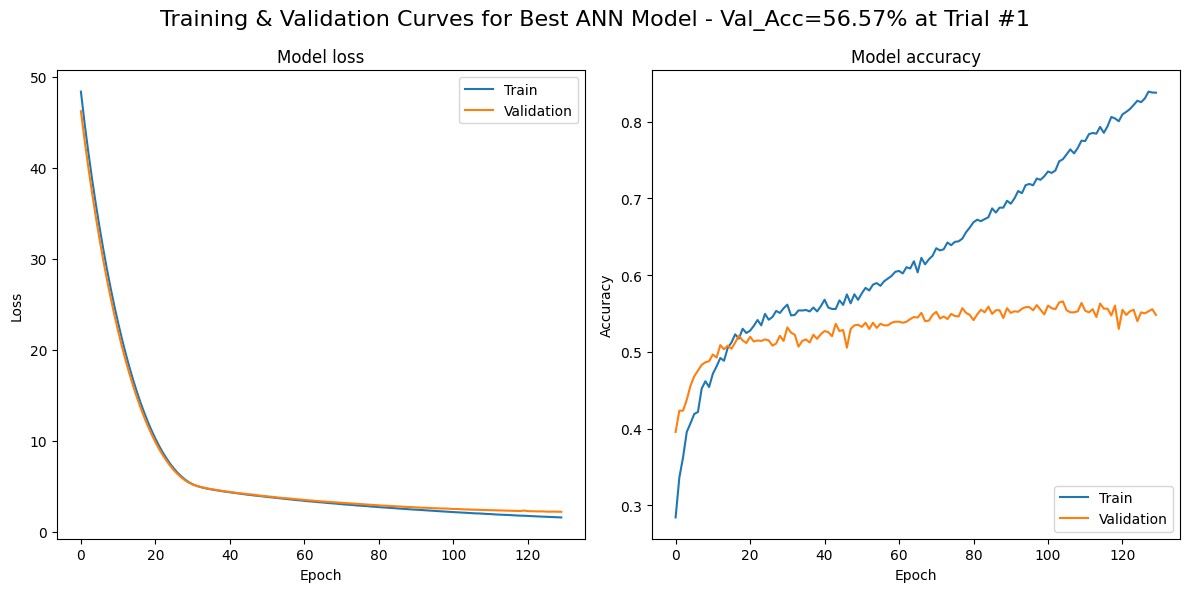

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


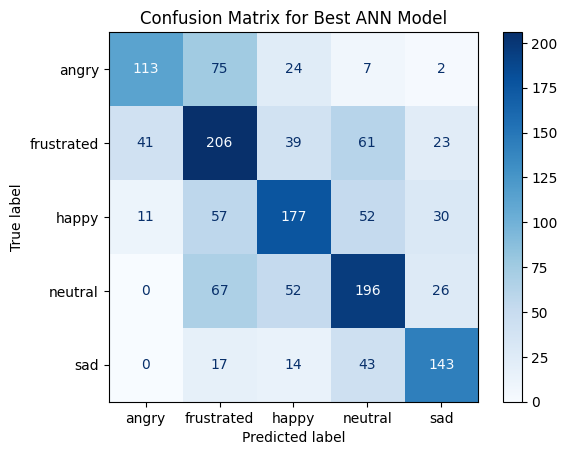


Accuracy = 56.572%

              precision    recall  f1-score   support

       angry       0.68      0.51      0.59       221
  frustrated       0.49      0.56      0.52       370
       happy       0.58      0.54      0.56       327
     neutral       0.55      0.57      0.56       341
         sad       0.64      0.66      0.65       217

    accuracy                           0.57      1476
   macro avg       0.59      0.57      0.57      1476
weighted avg       0.57      0.57      0.57      1476



In [10]:
max_acc, best_params, best_trial, best_model, phist, histories = tune_hyperparams(ntrials=20,feats=feats,max_epochs=500)

In [11]:
data = []
for params, acc in phist.items():
    hppms = dict(params)
    hppms['accuracy'] = acc
    data.append(hppms)
df2 = pd.DataFrame(data)
df2 = df2.reindex(sorted(df2.columns), axis=1)
df2 = df2[[col for col in sorted(df2.columns) if col != 'accuracy'] + ['accuracy']]
df2.sort_values('accuracy',ascending=False,inplace=True,ignore_index=True)
df2

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,BN_1,BN_2,BN_3,BN_4,KR_1,KR_2,KR_3,KR_4,adpLR,apply_smote,...,dropout_rate_4,learning_rate,num_HL,optimizer,rs_split,units_1,units_2,units_3,units_4,accuracy
0,False,False,False,NaN,l2,none,l1,NaN,False,False,...,NaN,0.002753,3,Adagrad,86,298,320,262.0,NaN,0.565718
1,False,True,NaN,NaN,none,l1l2,NaN,NaN,True,False,...,NaN,0.001535,2,RMSprop,86,368,408,NaN,NaN,0.550135
2,False,False,False,NaN,l2,l1l2,none,NaN,True,False,...,NaN,0.001112,3,RMSprop,86,374,274,370.0,NaN,0.548781
3,False,True,NaN,NaN,l1,none,NaN,NaN,True,True,...,NaN,0.000722,2,Adagrad,86,374,304,NaN,NaN,0.546748
4,True,False,False,True,none,l2,l1l2,l1,True,False,...,0.4408,0.000231,4,Adam,86,332,386,512.0,394.0,0.545393
5,False,False,True,False,none,l1,l2,none,False,False,...,0.3668,0.000710,4,Adam,86,304,384,302.0,484.0,0.537263
6,True,False,True,NaN,none,l2,l2,NaN,False,True,...,NaN,0.003746,3,RMSprop,86,384,474,418.0,NaN,0.537263
7,False,True,True,True,none,none,l1l2,none,True,True,...,0.2162,0.001862,4,SGD,86,402,362,504.0,454.0,0.535230
8,True,True,NaN,NaN,none,l1l2,NaN,NaN,False,False,...,NaN,0.001994,2,Adam,86,368,458,NaN,NaN,0.533875
9,False,False,NaN,NaN,l1,l1l2,NaN,NaN,True,True,...,NaN,0.001406,2,Adamax,86,366,322,NaN,NaN,0.532520


In [12]:
numerical_features = df2.iloc[:,:-1].select_dtypes(include=['int64', 'float64'])
categorical_features = df2.select_dtypes(include=['object', 'category','bool'])
correlation_matrix = numerical_features.corrwith(df2['accuracy'], method='pearson')
print(correlation_matrix.sort_values(ascending=False))

dropout_rate_2    0.320918
dropout_rate_3    0.296551
units_1           0.287017
learning_rate     0.154122
batch_size        0.083291
units_2          -0.017319
units_3          -0.025828
num_HL           -0.041963
dropout_rate_1   -0.119682
dropout_rate_4   -0.143374
units_4          -0.229737
rs_split               NaN
dtype: float64


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [13]:
categorical_features['accuracy'] = df2['accuracy']
for col in categorical_features.columns[:-1]:
    print(categorical_features.groupby(col)['accuracy'].mean())

BN_1
False    0.527033
True     0.510501
Name: accuracy, dtype: float64
BN_2
False    0.523148
True     0.512195
Name: accuracy, dtype: float64
BN_3
False    0.526016
True     0.506001
Name: accuracy, dtype: float64
BN_4
False    0.527947
True     0.514228
Name: accuracy, dtype: float64
KR_1
l1      0.493902
l1l2    0.488144
l2      0.535095
none    0.537166
Name: accuracy, dtype: float64
KR_2
l1      0.509621
l1l2    0.529423
l2      0.485434
none    0.544885
Name: accuracy, dtype: float64
KR_3
l1      0.546748
l1l2    0.469173
l2      0.533424
none    0.533875
Name: accuracy, dtype: float64
KR_4
l1      0.533198
l1l2    0.527778
l2      0.528794
none    0.505646
Name: accuracy, dtype: float64
adpLR
False    0.496612
True     0.533537
Name: accuracy, dtype: float64
apply_smote
False    0.526423
True     0.511111
Name: accuracy, dtype: float64
optimizer
Adadelta    0.444444
Adagrad     0.531391
Adam        0.533424
Adamax      0.530149
Nadam       0.525745
RMSprop     0.499051
SGD     